# Explorations in Churn

### This file utilizes a data set regarding voluntary customer churn in the telecom industry where customers are on some sort of contract involving international phone calling plans. The data set will be prepared for data analysis, exploratory data analysis will be performed and different types of models will be created including decision tree analysis, logistic regression, support vector classifier, and a random forest with optimized hyperparameters. The most influential features of the data set will be revealed.

In [2]:
#This file utilizes a data set regarding voluntary customer churn in the telecom industry where customers are on
#some sort of contract.  This data set features international phone calling plans. The data set will be prepared 
#for data analysis, exploratory data analysis will be performed and different types of models will be created including
#decision tree analysis, logistic regression, support vector classifier, and a random forest with optimized hyperparameters.
#The most influential features of the data set will be revealed. 

#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit



In [3]:
#Import the churn data set
df = pd.read_csv('churn.csv')

### You can find the churn data set that I used [here](https://data.world/earino/churn).

### Below is a summary of columns, size and data types of the intital data set.

In [4]:
#Explore the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account_Length  3333 non-null   int64  
 1   Vmail_Message   3333 non-null   int64  
 2   Day_Mins        3333 non-null   float64
 3   Eve_Mins        3333 non-null   float64
 4   Night_Mins      3333 non-null   float64
 5   Intl_Mins       3333 non-null   float64
 6   CustServ_Calls  3333 non-null   int64  
 7   Churn           3333 non-null   object 
 8   Intl_Plan       3333 non-null   object 
 9   Vmail_Plan      3333 non-null   object 
 10  Day_Calls       3333 non-null   int64  
 11  Day_Charge      3333 non-null   float64
 12  Eve_Calls       3333 non-null   int64  
 13  Eve_Charge      3333 non-null   float64
 14  Night_Calls     3333 non-null   int64  
 15  Night_Charge    3333 non-null   float64
 16  Intl_Calls      3333 non-null   int64  
 17  Intl_Charge     3333 non-null   f

### Below is the first five rows of the intital data set showing all of the intital features.

In [5]:
#Explore data colums
df.head()

,Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Churn,Intl_Plan,Vmail_Plan,...,Day_Charge,Eve_Calls,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,State,Area_Code,Phone
0,128,25,265.1,197.4,244.7,10.0,1,no,no,yes,...,45.07,99,16.78,91,11.01,3,2.70,KS,415,382-4657
1,107,26,161.6,195.5,254.4,13.7,1,no,no,yes,...,27.47,103,16.62,103,11.45,3,3.70,OH,415,371-7191
2,137,0,243.4,121.2,162.6,12.2,0,no,no,no,...,41.38,110,10.30,104,7.32,5,3.29,NJ,415,358-1921
3,84,0,299.4,61.9,196.9,6.6,2,no,yes,no,...,50.90,88,5.26,89,8.86,7,1.78,OH,408,375-9999
4,75,0,166.7,148.3,186.9,10.1,3,no,yes,no,...,28.34,122,12.61,121,8.41,3,2.73,OK,415,330-6626


In [6]:
# This tells us a great deal already as there are no missing values, We have our target in Churn, and there are some
#object variables that need to be converted.  Phone and Area Code can be dropped so let's do that now.

df = df.drop(['Area_Code', 'Phone'], axis = 1)

### This tells us a great deal already as there are no missing values, the target is Churn and there are some object variables that need to be converted.  Phone and Area Code can be dropped so let's do that now.

In [7]:
#Let's make sure that they are gone.
print(df.columns)

Index(['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 'Night_Mins',
       'Intl_Mins', 'CustServ_Calls', 'Churn', 'Intl_Plan', 'Vmail_Plan',
       'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls',
       'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State'],
      dtype='object')


### There are object columns that have to be converted to numeric for modeling unless we want to use a decision tree.  Single trees are great for EDA and visualization but have poor predictive power.  One of these values is the State variable. Let's take a look at it to see if this may be a relative variable.  One-hot encoding may be needed here but it will create 51 additonal variables and require deep learning.  We will drop the State variable and move forward.  

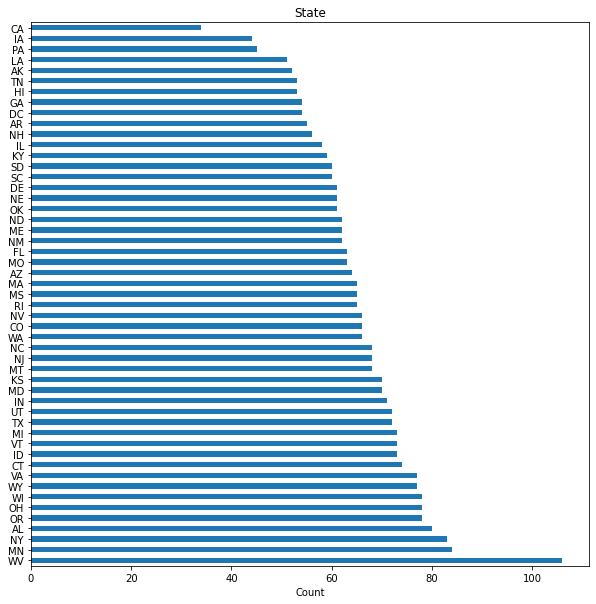

In [8]:
#There are object columns that have to be converted to numeric for modeling unless we want to use a decision tree. 
#Single trees are great for EDA and visualization but have poor predictive power.  One of these values is the State variable.
#Let's take a look at it to see if this may be a relative variable.  One-hot encoding may be needed here.

plt.figure(figsize=(10,10))
df.State.value_counts().plot(kind='barh')
plt.title('State')
plt.xlabel('Count')
plt.show()

### Let's see about the percentage of churn vs. no churn. If the percentage is below 5% then we may have an overfitting problem.

In [9]:
#What is going on in West Virginia?  California is the lowest which is strange for it's size. 
# This may need to be explored a little.  Let's see about the percentage of churn vs. no churn. 
# If the percantage is below 5% then we may have an overfitting problem.

print(df.groupby(['Churn']).size() / df.shape[0] * 100)

Churn
no     85.508551
yes    14.491449
dtype: float64


### Only around 14% of the samples have churned which is not ideal but we should be able to model the data.  **We may have to stratify the train and test split here.** Before we convert the categorical variables, let's do some feature engineering because there are some columns that may need to be combined or eliminated. The International, daytime, night time and evening call minutes can be divided by their respective total calls for average call minutes per call and let's check the columns/indexes.

In [10]:
#Only around 14% of the samples have churned which is not ideal but we should be able to model the data.
#Before we convert the categorical variables, let's do some feature engineering because there are some columns that
#may need to be combined or eliminated. The International, daytime, nighttime and evening call minutes can be divided
#by their respective total calls for average call minutes per call.  Let's do that now.

df['Avg_Day_Calls'] = df['Day_Mins'] / df['Day_Calls']
df['Avg_Eve_Calls'] = df['Eve_Mins'] / df['Eve_Calls']
df['Avg_Intl_Calls'] = df['Intl_Mins'] / df['Intl_Calls']
df['Avg_Night_Calls'] = df['Night_Mins'] / df['Night_Calls']

#And let's check the columns/indexes

print(df.columns)

Index(['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 'Night_Mins',
       'Intl_Mins', 'CustServ_Calls', 'Churn', 'Intl_Plan', 'Vmail_Plan',
       'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls',
       'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State', 'Avg_Day_Calls',
       'Avg_Eve_Calls', 'Avg_Intl_Calls', 'Avg_Night_Calls'],
      dtype='object')


### Now, we can create a new dataframe with the previous features dropped by subetting.  That way if there is an error, we can revert back to the original df.

In [11]:
#Now, we can create a new dataframe with the previous features dropped by subetting.  That way if there is an error, we can revert
#back to the original df.

df_new = df[['Account_Length', 'Vmail_Message', 'CustServ_Calls', 'Churn', 'Intl_Plan', 'Vmail_Plan', 'Day_Charge', 'Eve_Charge',
       'Night_Charge', 'Intl_Charge', 'State', 'Avg_Day_Calls',
       'Avg_Eve_Calls', 'Avg_Intl_Calls', 'Avg_Night_Calls' ]]
df_new.head()


,Account_Length,Vmail_Message,CustServ_Calls,Churn,Intl_Plan,Vmail_Plan,Day_Charge,Eve_Charge,Night_Charge,Intl_Charge,State,Avg_Day_Calls,Avg_Eve_Calls,Avg_Intl_Calls,Avg_Night_Calls
0,128,25,1,no,no,yes,45.07,16.78,11.01,2.70,KS,2.410000,1.993939,3.333333,2.689011
1,107,26,1,no,no,yes,27.47,16.62,11.45,3.70,OH,1.313821,1.898058,4.566667,2.469903
2,137,0,0,no,no,no,41.38,10.30,7.32,3.29,NJ,2.135088,1.101818,2.440000,1.563462
3,84,0,2,no,yes,no,50.90,5.26,8.86,1.78,OH,4.216901,0.703409,0.942857,2.212360
4,75,0,3,no,yes,no,28.34,12.61,8.41,2.73,OK,1.475221,1.215574,3.366667,1.544628


In [12]:
#Now that we have all of the columns we want, we have to decide how to handle the state data before we convert to binary 
#values.  

print(df_new.groupby('State')['Churn'].value_counts().head(20))
print(df_new.groupby('State')['Churn'].value_counts().tail(20))

State  Churn
AK     no       49
       yes       3
AL     no       72
       yes       8
AR     no       44
       yes      11
AZ     no       60
       yes       4
CA     no       25
       yes       9
CO     no       57
       yes       9
CT     no       62
       yes      12
DC     no       49
       yes       5
DE     no       52
       yes       9
FL     no       55
       yes       8
Name: Churn, dtype: int64
State  Churn
SD     no       52
       yes       8
TN     no       48
       yes       5
TX     no       54
       yes      18
UT     no       62
       yes      10
VA     no       72
       yes       5
VT     no       65
       yes       8
WA     no       52
       yes      14
WI     no       71
       yes       7
WV     no       96
       yes      10
WY     no       68
       yes       9
Name: Churn, dtype: int64


### Exploratory data analysis will now be performed on the final features.

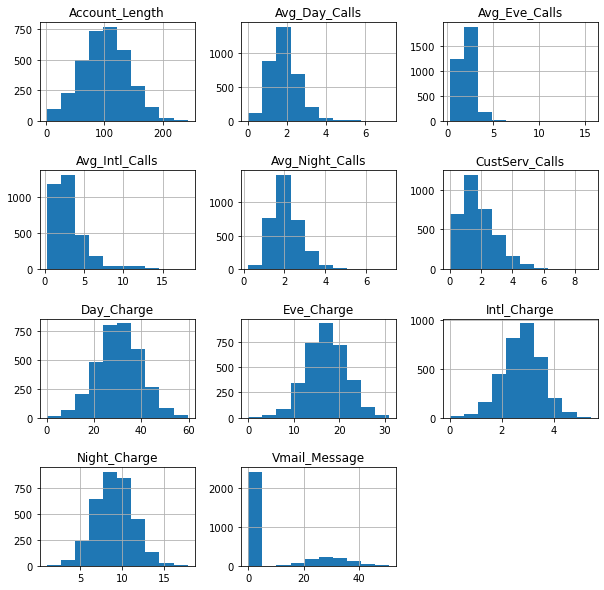

In [13]:
#We can see that different states have higher churn rates so some one-hot encoding would be the order of the day here. 
#But first, let's view some histograms.

df_new.hist(figsize=(10,10))
plt.subplots_adjust(hspace=0.5);

### Some of these values have a normal distribution but some are skewed, namely our new features. Voicemail messages appear more categorical but let's check if they are relevant to the target first. We will need to standardize the numerical variabes.

In [14]:
#Some of these values have a normal distribution but some are skewed, namely our new features. Voicemail messages
#appear more categorical but let's check if they are relevant to the target first. We will need to standardize numerical
#variabes.

print(df_new.nunique())

Account_Length      212
Vmail_Message        46
CustServ_Calls       10
Churn                 2
Intl_Plan             2
Vmail_Plan            2
Day_Charge         1667
Eve_Charge         1440
Night_Charge        933
Intl_Charge         162
State                51
Avg_Day_Calls      3259
Avg_Eve_Calls      3253
Avg_Intl_Calls      781
Avg_Night_Calls    3244
dtype: int64


### Essentially, what we see here is that Intl_Plan, Vmail_Plan and State are our categorical variables.  Churn is our target and should be removed before modeling.  First, the numerical fields will be standardized or scaled  using StandardScaler by removing the categorical variables.  For now, the target will remain so we can run a Decision Tree model.

In [15]:
#Essentially, what we see here is that Intl_Plan, Vmail_Plan and State are our categorical variables.  Churn is our target
#and should be removed before modeling.  First, we will standardize the numerical fields using StandardScaler by removing
#the categorical variables.  For now, we will leave in the target so we can run a Decision Tree. First, we will one-hot 
#encode the states.

df_state = pd.get_dummies(df['State'])
state = ['State']
cat = df_new.nunique()[df_new.nunique() < 3].keys().tolist()
numerical = [x for x in df_new.columns if x not in cat + state]

In [16]:
#Here, we will scale the numerical data.

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new[numerical])
df_scaled = pd.DataFrame(df_scaled, columns=numerical)

### We will merge categorical and numerical variables back together in a final dataframe and make categorical variables binary. The state data will be omitted as the previous graph shows only limited variability and one-hot encoding introduced 51 new variables making a decision tree unreadable.  We can re-add this data later if necessary. The data set is ready for modeling.

In [48]:
#We will merge categorical and numerical back together in a final dataframe and make categorical variables binary.
# The state data will be omitted as the previous graph shows only limited variability and one-hot encoding introduced
# 51 new variables making a decision tree unreadable.  We can re-add this data later if necessary.

categorical = df_new[['Churn', 'Intl_Plan', 'Vmail_Plan']]
dff = pd.concat([categorical, df_scaled], axis = 1)
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   object 
 1   Intl_Plan        3333 non-null   object 
 2   Vmail_Plan       3333 non-null   object 
 3   Account_Length   3333 non-null   float64
 4   Vmail_Message    3333 non-null   float64
 5   CustServ_Calls   3333 non-null   float64
 6   Day_Charge       3333 non-null   float64
 7   Eve_Charge       3333 non-null   float64
 8   Night_Charge     3333 non-null   float64
 9   Intl_Charge      3333 non-null   float64
 10  Avg_Day_Calls    3331 non-null   float64
 11  Avg_Eve_Calls    3332 non-null   float64
 12  Avg_Intl_Calls   3315 non-null   float64
 13  Avg_Night_Calls  3333 non-null   float64
dtypes: float64(11), object(3)
memory usage: 364.7+ KB


In [49]:
#Now we will convert our categorical variables and our target into binary variables and call a Decision Tree for EDA.

dff['Vmail_Plan'] = dff['Vmail_Plan'].replace({'no':0, 'yes':1})
dff['Intl_Plan'] = dff['Intl_Plan'].replace({'no':0, 'yes':1})
dff['Churn'] = dff['Churn'].replace({'no':0, 'yes':1})

In [50]:
#Let's check our data with head() to ensure that we are ready for modeling.
dff.head()

,Churn,Intl_Plan,Vmail_Plan,Account_Length,Vmail_Message,CustServ_Calls,Day_Charge,Eve_Charge,Night_Charge,Intl_Charge,Avg_Day_Calls,Avg_Eve_Calls,Avg_Intl_Calls,Avg_Night_Calls
0,0,0,1,0.676489,1.234883,-0.427932,1.567036,-0.070427,0.866029,-0.085690,0.734786,-0.141600,0.097745,0.841837
1,0,0,1,0.149065,1.307948,-0.427932,-0.334013,-0.107549,1.059390,1.241169,-0.763862,-0.265233,0.643354,0.533006
2,0,0,0,0.902529,-0.591760,-1.188218,1.168464,-1.573900,-0.755571,0.697156,0.358938,-1.291940,-0.297454,-0.744616
3,0,1,0,-0.428590,-0.591760,0.332354,2.196759,-2.743268,-0.078806,-1.306401,3.205103,-1.805666,-0.959769,0.170001
4,0,1,0,-0.654629,-0.591760,1.092641,-0.240041,-1.037939,-0.276562,-0.045885,-0.543203,-1.145258,0.112491,-0.771162


### Now, we will define our target as X and the rest of dff as y and run a decision tree. This will be used for plotting and visualization as opposed to assessing model performance. We will try a test size of 1/4 and check the split. Wow, that is a ridiculous test accuracy. I almost wonder if I am doing something wrong.  Let's check and print out the tree after optimizing the hyperparameter for maximum depth to prevent overfitting. We can see below that somewhere between 3 and 8 is advantageous.

In [53]:
#Now, we will define our target as X and the rest of dff as y and run a decision tree. This will
#be used for plotting and visualization as opposed to assessing model performance. 
#We will try a test size of 1/4 and check the split. 

y = dff['Churn']
X = dff.drop(['Churn'], axis=1)

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print(X_train.shape[0] / X.shape[0])
print(X_test.shape[0] / X.shape[0])



0.7497749774977498
0.2502250225022502


In [54]:
#Let's see what kind of tree we can get and what features the tree displays as important.
clf = tree.DecisionTreeClassifier(max_depth = 7, criterion = 'gini', splitter = 'best')
modelT = clf.fit(X_train, y_train)
pred_y = modelT.predict(X_test)
print("Training accuracy: ", np.round(clf.score(X_train, y_train), 3))
print("Test accuracy: ", np.round(accuracy_score(y_test, pred_y), 3))

Training accuracy:  0.969
Test accuracy:  0.928


In [55]:
#Wow, that is a ridiculous test accuracy. I almost wonder if I am doing something wrong.  Let's check and print out the tree.

test_precision = round(precision_score(y_test, pred_y), 4)
test_recall = round(recall_score(y_test, pred_y), 4)
print('Test precision: {}, Test recall: {}'.format(test_precision, test_recall))

Test precision: 0.8105, Test recall: 0.6471


In [56]:
#This is pretty good but let's optimize the tree.  
depth_list = list(range(2, 15))
depth_tuning = np.zeros((len(depth_list), 4))
depth_tuning[:,0] = depth_list
for index in range(len(depth_list)):
    clf = DecisionTreeClassifier(max_depth=depth_list[index])
    clf.fit(X_train, y_train)
    pred_y = clf.predict(X_test)
    depth_tuning[index,1] = accuracy_score(y_test, pred_y)
    depth_tuning[index,2] = precision_score(y_test, pred_y)
    depth_tuning[index,3] = recall_score(y_test, pred_y)
col_names = ['Max_Depth', 'Accuracy', 'Precision', 'Recall']
print(pd.DataFrame(depth_tuning, columns=col_names))

    Max_Depth  Accuracy  Precision    Recall
0         2.0  0.876499   0.710526  0.226891
1         3.0  0.902878   0.806452  0.420168
2         4.0  0.919664   0.893939  0.495798
3         5.0  0.934053   0.863636  0.638655
4         6.0  0.931655   0.844444  0.638655
5         7.0  0.928058   0.817204  0.638655
6         8.0  0.925659   0.806452  0.630252
7         9.0  0.928058   0.817204  0.638655
8        10.0  0.930456   0.790476  0.697479
9        11.0  0.926859   0.773585  0.689076
10       12.0  0.932854   0.811881  0.689076
11       13.0  0.924460   0.754545  0.697479
12       14.0  0.924460   0.750000  0.705882


[Text(697.5, 951.3000000000001, 'CustServ_Calls <= 1.558\ngini = 0.249\nsamples = 2499\nvalue = [2135, 364]'),
 Text(348.75, 679.5, 'Vmail_Message <= 1.473\ngini = 0.201\nsamples = 2346\nvalue = [2080, 266]'),
 Text(174.375, 407.70000000000005, 'Churn <= 0.5\ngini = 0.149\nsamples = 2164\nvalue = [1988, 176]'),
 Text(87.1875, 135.89999999999998, 'gini = 0.095\nsamples = 1968\nvalue = [1870, 98]'),
 Text(261.5625, 135.89999999999998, 'gini = 0.479\nsamples = 196\nvalue = [118, 78]'),
 Text(523.125, 407.70000000000005, 'CustServ_Calls <= -0.1\ngini = 0.5\nsamples = 182\nvalue = [92, 90]'),
 Text(435.9375, 135.89999999999998, 'gini = 0.343\nsamples = 100\nvalue = [22, 78]'),
 Text(610.3125, 135.89999999999998, 'gini = 0.25\nsamples = 82\nvalue = [70, 12]'),
 Text(1046.25, 679.5, 'Account_Length <= -0.117\ngini = 0.461\nsamples = 153\nvalue = [55, 98]'),
 Text(871.875, 407.70000000000005, 'Day_Charge <= -0.322\ngini = 0.342\nsamples = 119\nvalue = [26, 93]'),
 Text(784.6875, 135.8999999999

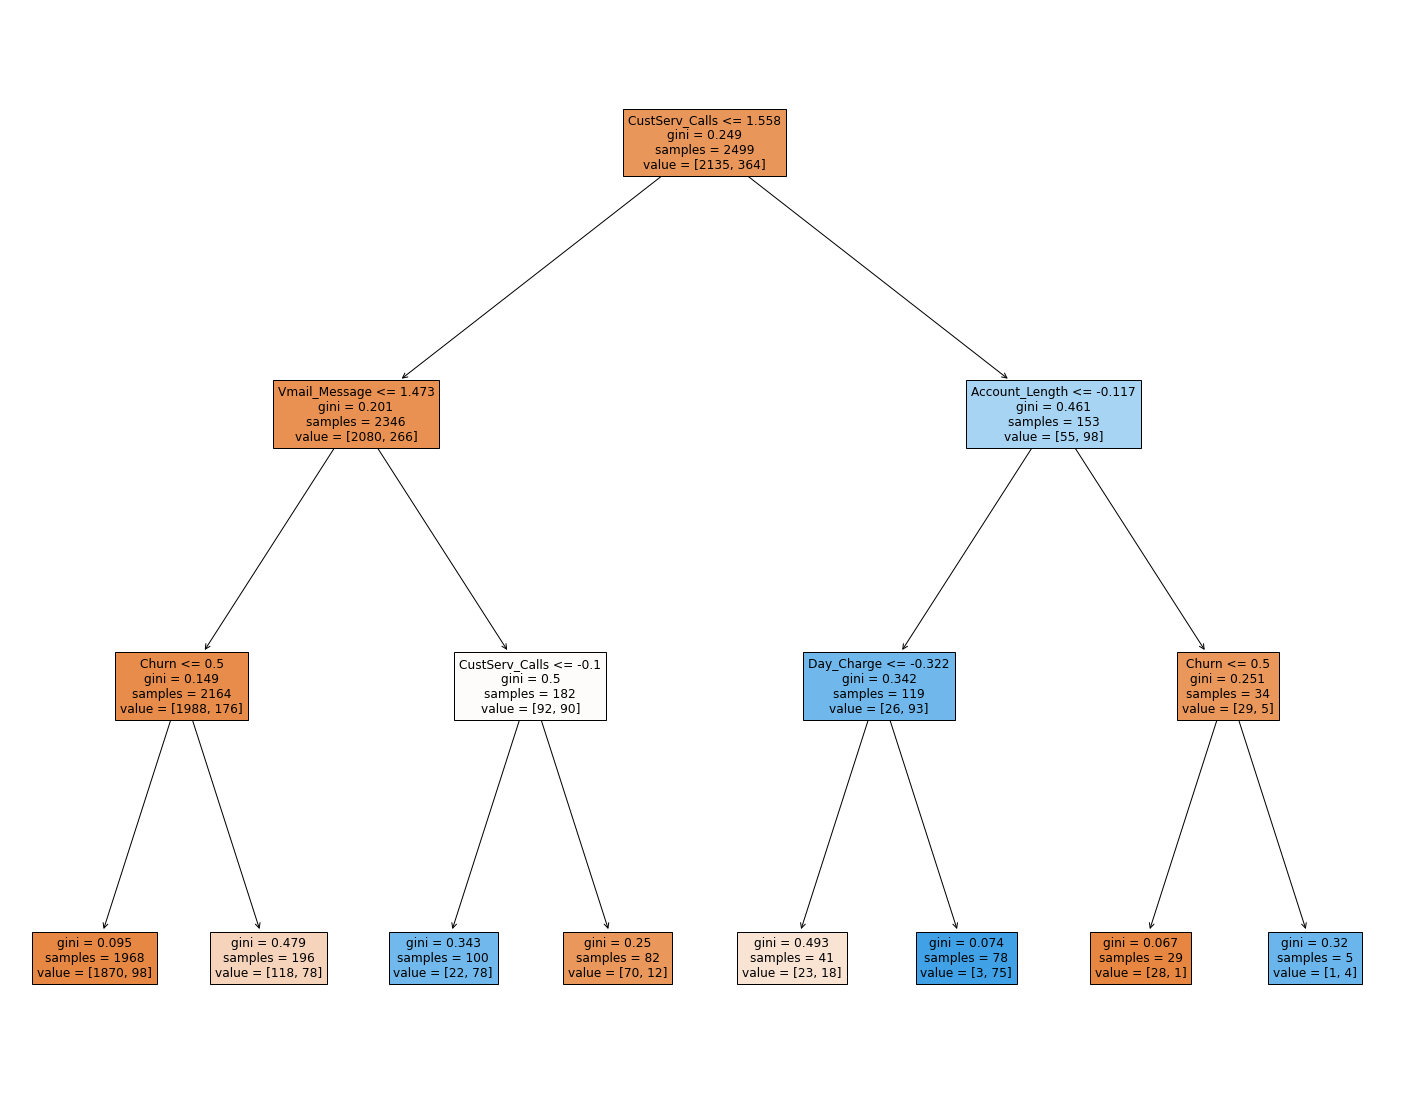

In [59]:
#We can see that somewhere between 3 and 8 is advantageous. Let's try a tree depth of 3. Next, we will determine which 
#features the decision tree finds to be most influential and plot the tree.

clf = tree.DecisionTreeClassifier(max_depth = 3, criterion = 'gini', splitter = 'best')
modelT = clf.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
tree.plot_tree(clf, feature_names = ['Churn', 'Intl_Plan', 'Vmail_Plan', 'Account_Length', 'Vmail_Message', 'CustServ_Calls', 'Day_Charge', 'Eve_Charge',
       'Night_Charge', 'Intl_Charge', 'Avg_Day_Calls',
       'Avg_Eve_Calls', 'Avg_Intl_Calls', 'Avg_Night_Calls'], filled=True)





### It looks like the tree split on customer service calls first and then on voice mail messages and account length. This is only one tree though so other models will be explored but it is good to take a first look.  On to logistic regression where we can use information to determine best features.

In [60]:
#It looks like the tree split on customer service calls first and then on voice mail messages and account length.
#This is only one tree though so other models will be explored but it is good to take a first look.
#On to logistic regression where we can use information to determine best features.

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
test_accuracy = accuracy_score(y_test, pred_y)
print('Test accuracy for logistic regression: ', round(test_accuracy, 4))


Test accuracy for logistic regression:  0.9245


### The accuracy is not quite as good as the decision tree but we cannot rely on just one tree.  Let's see if we can optimize the logistic regression model with lasso regularization that helps with overfitting and maybe some feature selection.

In [61]:
#The accuracy is not quite as good as the decision tree but we cannot rely on just one tree.  Let's see if we can 
#optimize the logistic regression model with lasso regularization that helps with overfitting and maybe some feature selection.

C = [1, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01, 0.005]
l1_metrics = np.zeros((len(C), 5))
l1_metrics[:,0] = C
for index in range(0, len(C)):
    logreg = LogisticRegression(penalty = 'l1', C=C[index], solver='liblinear')
    logreg.fit(X_train, y_train)
    pred_Y = logreg.predict(X_test)
    l1_metrics[index, 1] = np.count_nonzero(logreg.coef_)
    l1_metrics[index, 2] = accuracy_score(y_test, pred_Y)
    l1_metrics[index, 3] = precision_score(y_test, pred_Y)
    l1_metrics[index, 4] = recall_score(y_test, pred_Y)
col_names = ['C', 'Non-Zero Coefficients', 'Accuracy', 'Precision', 'Recall']
print(pd.DataFrame(l1_metrics, columns=col_names))


       C  Non-Zero Coefficients  Accuracy  Precision    Recall
0  1.000                   13.0  0.862110   0.535714  0.252101
1  0.500                   13.0  0.860911   0.527273  0.243697
2  0.250                   11.0  0.862110   0.540000  0.226891
3  0.100                   10.0  0.859712   0.521739  0.201681
4  0.050                   10.0  0.859712   0.531250  0.142857
5  0.025                    8.0  0.862110   0.833333  0.042017
6  0.010                    2.0  0.857314   0.000000  0.000000
7  0.005                    0.0  0.857314   0.000000  0.000000


C:\Users\Owner\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Owner\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Well, not much can be said with such low recall numbers.  At 8 coefficients, precision is high but recall is really low.  A value of 10 non-zero coefficients may be good choice.  There must be lot of false negatives in this model. 

In [62]:
#Well, not much can be said with such low recall numbers.  At 8 coefficients, precision is high but recall is really low.
# A value of 10 may be good choice.  There must be lot of false negatives in this model.  

logreg = LogisticRegression(penalty = 'l1', C=1, solver='liblinear')
logreg.fit(X_train, y_train)
pred_y = logreg.predict(X_test)
feature_names = pd.DataFrame(X_train.columns, columns = ['Feature'])
log_coef = pd.DataFrame(np.transpose(logreg.coef_), columns = ['Coefficient'])
coefficients = pd.concat([feature_names, log_coef], axis = 1)
coefficients['Exp_Coefficient'] = np.exp(coefficients['Coefficient'])
coefficients = coefficients[coefficients['Coefficient']!=0]
print(coefficients.sort_values(by=['Exp_Coefficient']))
                           

            Feature  Coefficient  Exp_Coefficient
1        Vmail_Plan    -2.024492         0.132061
10    Avg_Eve_Calls    -0.062619         0.939302
9     Avg_Day_Calls    -0.017728         0.982428
2    Account_Length     0.048755         1.049964
12  Avg_Night_Calls     0.061457         1.063384
7      Night_Charge     0.160371         1.173946
8       Intl_Charge     0.184835         1.203020
11   Avg_Intl_Calls     0.201229         1.222905
6        Eve_Charge     0.418178         1.519190
3     Vmail_Message     0.519393         1.681007
4    CustServ_Calls     0.623876         1.866148
5        Day_Charge     0.760530         2.139409
0         Intl_Plan     2.123355         8.359135


In [63]:
#Looks like the international plan may have something to do with churn. Let's get our data into a Random Forest Model.  

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
pred_y = clf.predict(X_test)
print(clf.score(X_test, y_test))

0.9400479616306955


In [64]:
#Ok, let's check a support vector machine classifier and compare the two.
clf_svm = SVC()
clf_svm.fit(X_train, y_train)
pred_y = clf.predict(X_test)
print(clf.score(X_test, y_test))

0.9400479616306955


### A support vector classifier and random forest have the same exact. That is quite interesting and maybe the data has been overfit.  Let's go with the Random Forest and find out. Let's take a look at a confusion matrix which will give us a sense of true and false positives and negatives and the ROC curve.

Training accuracy for random forest:  1.0
Test accuracy for random forest:  0.94
Test precision for random forest: 0.9059, Test recall for random forest: 0.6471
Confusion Matrix for random forest: 
[[707   8]
 [ 42  77]]


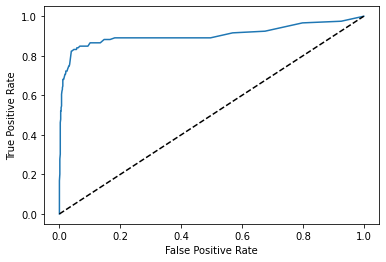

Area under the ROC curve for random forest:  0.9057
F1 score for random forest:  0.7549


In [68]:
#That is quite interesting and maybe the data has been overfit.  Let's go with the Random Forest and find out. 
#Let's take a look at a confusion matrix which will give us a sense of true and false positives and negatives and the
#ROC curve

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
pred_y = clf.predict(X_test)


print("Training accuracy for random forest: ", np.round(clf.score(X_train, y_train), 3))
print("Test accuracy for random forest: ", np.round(accuracy_score(y_test, pred_y), 3))
test_precision_rf = round(precision_score(y_test, pred_y), 4)
test_recall_rf = round(recall_score(y_test, pred_y), 4)
print('Test precision for random forest: {}, Test recall for random forest: {}'.format(test_precision_rf, test_recall_rf))

print("Confusion Matrix for random forest: ")
print(confusion_matrix(y_test, pred_y))

y_pred_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)

# Add labels and diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.show()

#Let's take a look at the area under the ROC curve.

print("Area under the ROC curve for random forest: ", np.round(roc_auc_score(y_test, y_pred_prob), 4))

#Now we will view the F1 score which is precision and recall in a single metric.

print("F1 score for random forest: ", np.round(f1_score(y_test, pred_y), 4))


### The Random Forest Classifier seems to be a pretty good model. Now, we are going to use a cross-validation method to optimize the model called GridSearchCV.

In [69]:
#The Random Forest Classifier seems to be a pretty good model. Now, we are going to use a cross-validation method to 
#optimize the model called GridSearchCV.  

param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
grid_search = GridSearchCV(clf, param_grid)
grid_search.fit(X, y)
print(grid_search.best_params_)


{'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 10}


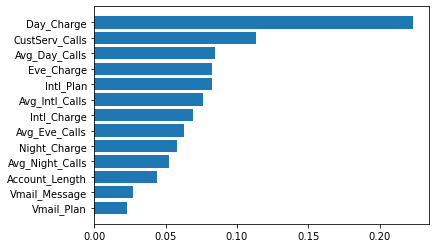

In [70]:
#Now, we will take a look at important features.

importances = clf.feature_importances_
sorted_index = np.argsort(importances)

labels = X.columns[sorted_index]

plt.barh(range(X.shape[1]), importances[sorted_index], tick_label=labels)
plt.show()

### We will run it all again with the final dataframe and see what the results are after we create a new partition. This time, we will use a stratified split which means that we can guarantee about 14% of the test set will also have churn = 1.  We will also set the random state to ensure the same set is used for all models.

In [71]:
#We will run it all again with the final dataframe and see what the results are after we create a new partition. This time,
#we will use a stratified split which means that we can guarantee about 14% of the test set will also have churn = 1.  We
#will also set the random state to ensure the same set is used for all models.

y = dfff['Churn']
X = dfff.drop(['Churn'], axis=1)
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)
sss = StratifiedShuffleSplit(n_splits=1, test_size = 0.25, random_state=12)

for train, test in sss.split(X, y):
    X_train = X.iloc[train]
    y_train = y.iloc[train]
    X_test = X.iloc[test]
    y_test = y.iloc[test]
print(y_train.value_counts())
print(y_test.value_counts())

print(y_train.value_counts() / len(y_train))
print(y_test.value_counts() / len(y_test))

print(X_train.shape[0] / X.shape[0])
print(X_test.shape[0] / X.shape[0])


0    2137
1     362
Name: Churn, dtype: int64
0    713
1    121
Name: Churn, dtype: int64
0    0.855142
1    0.144858
Name: Churn, dtype: float64
0    0.854916
1    0.145084
Name: Churn, dtype: float64
0.7497749774977498
0.2502250225022502


### As you can see, the training and test splits have roughly the same ratio of churn customers as the original data set.  Also, We have preserved a train test split of 75/25.  Let's see what our metrics look like now with optimal parameters:

Training accuracy for random forest:  1.0
Test accuracy for random forest:  0.932
Test precision for random forest: 0.8478, Test recall for random forest: 0.6446
Confusion Matrix for random forest: 
[[699  14]
 [ 43  78]]


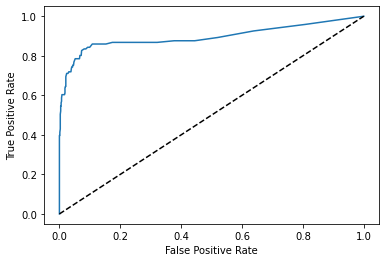

Area under the ROC curve for random forest:  0.8952
F1 score for random forest:  0.7324


In [74]:
#As you can see, the training and test splits have roughly the same ratio of churn customers as the original data set.
#Also, We have preserved a train test split of 75/25.  Let's see what our metrics look like now with optimal parameters:

clf = RandomForestClassifier(criterion = 'gini', max_features = 10)
clf.fit(X_train, y_train)
pred_y = clf.predict(X_test)

print("Training accuracy for random forest: ", np.round(clf.score(X_train, y_train), 3))
print("Test accuracy for random forest: ", np.round(accuracy_score(y_test, pred_y), 3))
test_precision_rf = round(precision_score(y_test, pred_y), 4)
test_recall_rf = round(recall_score(y_test, pred_y), 4)
print('Test precision for random forest: {}, Test recall for random forest: {}'.format(test_precision_rf, test_recall_rf))

print("Confusion Matrix for random forest: ")
print(confusion_matrix(y_test, pred_y))

y_pred_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)

# Add labels and diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.show()

#Let's take a look at the area under the ROC curve.

print("Area under the ROC curve for random forest: ", np.round(roc_auc_score(y_test, y_pred_prob), 4))

#Now we will view the F1 score which is precision and recall in a single metric.

print("F1 score for random forest: ", np.round(f1_score(y_test, pred_y), 4))


### The precision went down as there are more false positives.  Good thing we used a stratified split and parameter tuning. The numbers are relatively similar so let's look at the best parameters and best features. Now, we are going to use GridSearchCV for some final tuning. 

In [78]:
#The precision went down as there are more false positives.  Good thing we used a stratified split and parameter tuning. 
# The numbers are relatively similar so let's look at the best parameters and best features. Now, we are going to 
#use GridSearchCV on the final dataframe.  

param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
grid_search = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=5, n_jobs=4, refit=True)
grid_search.fit(X, y)
print(grid_search.best_params_)

{'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 3}


### Interesting, the criterion changed to entropy! Additionally, max features has been reduced to 3 and bootstrapping must be set to false.  Let's also increase the number of trees to 400. 

Training accuracy for random forest:  1.0
Test accuracy for random forest:  0.934
Test precision for random forest: 0.8587, Test recall for random forest: 0.6529
Confusion Matrix for random forest: 
[[700  13]
 [ 42  79]]


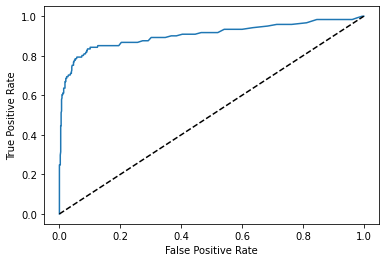

Area under the ROC curve for random forest:  0.9052
F1 score for random forest:  0.7418


In [79]:
#Interesting, the criterion changed to entropy! Additionally, max features has been reduced to 3 and bootstrapping must be set
#to false.  Let's also increase the number of trees to 400.  

clf = RandomForestClassifier(n_estimators = 400, bootstrap = False, criterion = 'entropy', max_features = 3)
clf.fit(X_train, y_train)
pred_y = clf.predict(X_test)

print("Training accuracy for random forest: ", np.round(clf.score(X_train, y_train), 3))
print("Test accuracy for random forest: ", np.round(accuracy_score(y_test, pred_y), 3))
test_precision_rf = round(precision_score(y_test, pred_y), 4)
test_recall_rf = round(recall_score(y_test, pred_y), 4)
print('Test precision for random forest: {}, Test recall for random forest: {}'.format(test_precision_rf, test_recall_rf))

print("Confusion Matrix for random forest: ")
print(confusion_matrix(y_test, pred_y))

y_pred_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)

# Add labels and diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.show()

#Let's take a look at the area under the ROC curve.

print("Area under the ROC curve for random forest: ", np.round(roc_auc_score(y_test, y_pred_prob), 4))

#Now we will view the F1 score which is precision and recall in a single metric.

print("F1 score for random forest: ", np.round(f1_score(y_test, pred_y), 4))


### A slight improvement so I will take it.  Finally, we will observe the most predictive features of the Random Forest Model.

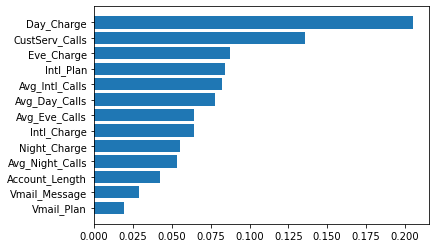

In [80]:
#A slight improvement so I will take it.  Finally, we will observe the most predictive features 
#of the Random Forest Model.

importances = clf.feature_importances_
sorted_index = np.argsort(importances)

labels = X.columns[sorted_index]

plt.barh(range(X.shape[1]), importances[sorted_index], tick_label=labels)
plt.show()

### Average day calls drop down and Day charge looks to be the consistent major predictive feature. Customer service calls are second on the list.  It turns out that this is different than our decision tree so it was a good idea to use ensemble methods for prediction.  Now, we will try randomized search since we have 4 hyperparameters and a large amount of data. We will enter these hyperparameters into the model to see what kind of metrics we get.

In [82]:
#Now, we will try randomized search since we have 4 hyperparameters and a large amount of data.
#We will enter these hyperparameters into the model to see what kind of metrics we get.

param_grid = {"max_depth": list(range(5, 26)),
              "max_features": ['auto', 'sqrt'],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
random_search = RandomizedSearchCV(clf, param_distributions = param_grid, n_iter = 5, scoring='roc_auc', cv=5, n_jobs=4, refit=True)
random_search.fit(X, y)
print(random_search.best_params_)

{'max_features': 'sqrt', 'max_depth': 12, 'criterion': 'entropy', 'bootstrap': False}


Training accuracy for random forest:  0.987
Test accuracy for random forest:  0.934
Test precision for random forest: 0.8667, Test recall for random forest: 0.6446
Confusion Matrix for random forest: 
[[701  12]
 [ 43  78]]


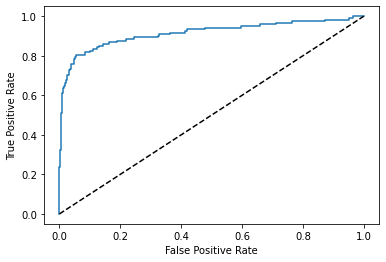

Area under the ROC curve for random forest:  0.9144
F1 score for random forest:  0.7393


In [83]:
clf = RandomForestClassifier(n_estimators = 400, bootstrap = False, criterion = 'entropy', max_features = 'sqrt', max_depth = 12)
clf.fit(X_train, y_train)
pred_y = clf.predict(X_test)

print("Training accuracy for random forest: ", np.round(clf.score(X_train, y_train), 3))
print("Test accuracy for random forest: ", np.round(accuracy_score(y_test, pred_y), 3))
test_precision_rf = round(precision_score(y_test, pred_y), 4)
test_recall_rf = round(recall_score(y_test, pred_y), 4)
print('Test precision for random forest: {}, Test recall for random forest: {}'.format(test_precision_rf, test_recall_rf))

print("Confusion Matrix for random forest: ")
print(confusion_matrix(y_test, pred_y))

y_pred_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)

# Add labels and diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.show()

#Let's take a look at the area under the ROC curve.

print("Area under the ROC curve for random forest: ", np.round(roc_auc_score(y_test, y_pred_prob), 4))

#Now we will view the F1 score which is precision and recall in a single metric.

print("F1 score for random forest: ", np.round(f1_score(y_test, pred_y), 4))


# Conclusion

### The numbers for Random Search cross validation and Grid Search cross validation are very similar.  There may not be much more hyperparameter tuning that can be done but it would be interesting to see if Bayesian or Genetic methods could be used to determine the most optimum model or if a combination of randomized and grid search can be used to narrow in on certain spaces of hyperparameters and use grid search on those spaces to surely find the best model.  Still, the area under the ROC curve is above 0.91 and the F1 score, which is a relation of the precision and recall for the model is quite high at almost 0.74 although the test accuracy did not change much after raising the number of trees to 400 from the default.